# Drifter Simulations

***

In [34]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from salishsea_tools import viz_tools

from parcels import FieldSet, ParticleSet, JITParticle, ErrorCode, AdvectionRK4

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

### Local functions

In [3]:
def make_prefix(date, path, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix


def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()


def mtime2datetime(mtime):
    """Convert matlab time to python datetime object
    """
    
    pytime = datetime.fromordinal(int(mtime) - 366) + timedelta(days=mtime%1)
    
    return pytime

***

### Load drifters and definitions

In [4]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201905',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc',
    'drifters': '/ocean/shared/drifters/data/L3/Salish_L3_20190728T103529.mat',
    'out': '/data/bmoorema/results/parcels/drifters_base',
}

# Load NEMO geolocation
grid = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])

# Define Gaussian point cloud
n = 50   # number of particles
r = 10   # radius of particle cloud [m]
deg2m = 111000 * np.cos(50 * np.pi / 180)
var = (r / (deg2m * 3))**2
x_offset, y_offset = np.random.multivariate_normal([0, 0], [[var, 0], [0, var]], n).T

# Duration and timestep [s]
duration = timedelta(days=5)
dt = 90

# Load drifters
drifters = loadmat(paths['drifters'])['drift'][0]

# Construct list of deployments inside SSC domain
IDs, IDout = list(np.unique(drifters['id'].astype(int))), []
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    if (drifters['lon'][dindex][0] < -125) and (drifters['lat'][dindex][0] < 49): IDout.append(ID)
    if mtime2datetime(float(drifters['mtime'][dindex][0])).year < 2016: IDout.append(ID)
    if ID > 1000: IDout.append(ID)
IDout = list(np.unique(IDout))
for ID in IDout: IDs.remove(ID)

Group deployments by date and duration.

In [5]:
# Browse deployments
k = 0
for ID in IDs:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start, end = [mtime2datetime(float(drifters['mtime'][dindex][t])) for t in [0, -1]]
    if (end - start).days >= 5:
        k += 1
        print(f'{k:02d}: {ID:03d},', start.strftime('%Y-%b-%d %H:%M,'), f'{(end-start).days:02} days')

01: 003, 2016-Apr-18 18:17, 06 days


***

### Simulations

In [6]:
# Loop through drifters
for ID in IDs:
    
    # Create index and date identifiers for drifter ID
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start, end = [mtime2datetime(float(drifters['mtime'][dindex][i])) for i in [0, -1]]
    
    # If the drifter was reporting at sea for at least 5 days, proceed
    if (end - start).days >= 5:

        # Define run paths
        fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
        outfile = os.path.join(paths['out'], fn)

        # Build filenames
        Ulist, Vlist = [], []
        for day in range(duration.days + 3):
            path_NEMO = make_prefix(start + timedelta(days=day), paths['NEMO'])
            Ulist.append(path_NEMO + '_grid_U.nc')
            Vlist.append(path_NEMO + '_grid_V.nc')

        # Load NEMO forcing
        filenames = {
            'U': {'lon': paths['coords'], 'lat': paths['coords'], 'data': Ulist},
            'V': {'lon': paths['coords'], 'lat': paths['coords'], 'data': Vlist},
        }
        variables = {'U': 'vozocrtx', 'V': 'vomecrty'}
        dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        field_set = FieldSet.from_nemo(filenames, variables, dimensions)

        # Execute run
        lon, lat = drifters['lon'][dindex][0] + x_offset, drifters['lat'][dindex][0] + y_offset
        pset = ParticleSet.from_list(field_set, JITParticle, lon=lon, lat=lat, time=start)
        pset.execute(
            pset.Kernel(AdvectionRK4), runtime=duration, dt=dt,
            output_file=pset.ParticleFile(name=outfile, outputdt=timedelta(hours=1)),
            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
        )

         It will be opened with no decoding. Filling values might be wrongly parsed.
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/5395efdca689402ed75faedeb1b8fea3_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-XFGBLEDC.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-XFGBLEDC" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:16 Time:  0:01:16
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/ab3bad1b532a4ec218458f4c40ec9179_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-IWPNBLZS.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-IWPNBLZS" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:05 Time:  0:01:05
INFO: Compiled JITParticleAdvec

100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:16 Time:  0:01:16
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/40684f03ff45d16ea09bb224e12cddef_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-MOXOKCLD.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-MOXOKCLD" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:23 Time:  0:01:23
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/73dd2feab81e30aae49966047b9bff18_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-EBEDLQJQ.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-EBEDLQJQ" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:27 Time:  0:01:27
INFO: Compiled JITParticleAdvectionR

INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-VRLFLRUW" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:25 Time:  0:01:25
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/7af2a171cc2853647d565954b42d906e_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-AQKTNJLG.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-AQKTNJLG" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:28 Time:  0:01:28
INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-1896/7f889c89e7732d5fae2f6d406ce204a6_0.so
INFO: Temporary output files are stored in /data/bmoorema/results/parcels/drifters_base/out-MZBXBRDW.
INFO: You can use "parcels_convert_npydir_to_netcdf /data/bmoorema/results/parcels/drifters_base/out-MZBXBRDW" to co

OSError: FieldSet file not found: /results/SalishSea/hindcast.201905/23jan18/SalishSea_1h_20180123_20180123_grid_U.nc

## Skill score comparisons

[Liu and Weisberg 2011, JGR Oceans](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2010JC006837)

$$\left. s = \sum_{i=1}^Nd_i \middle/ \sum_{i=1}^NI_{oi} \right.$$

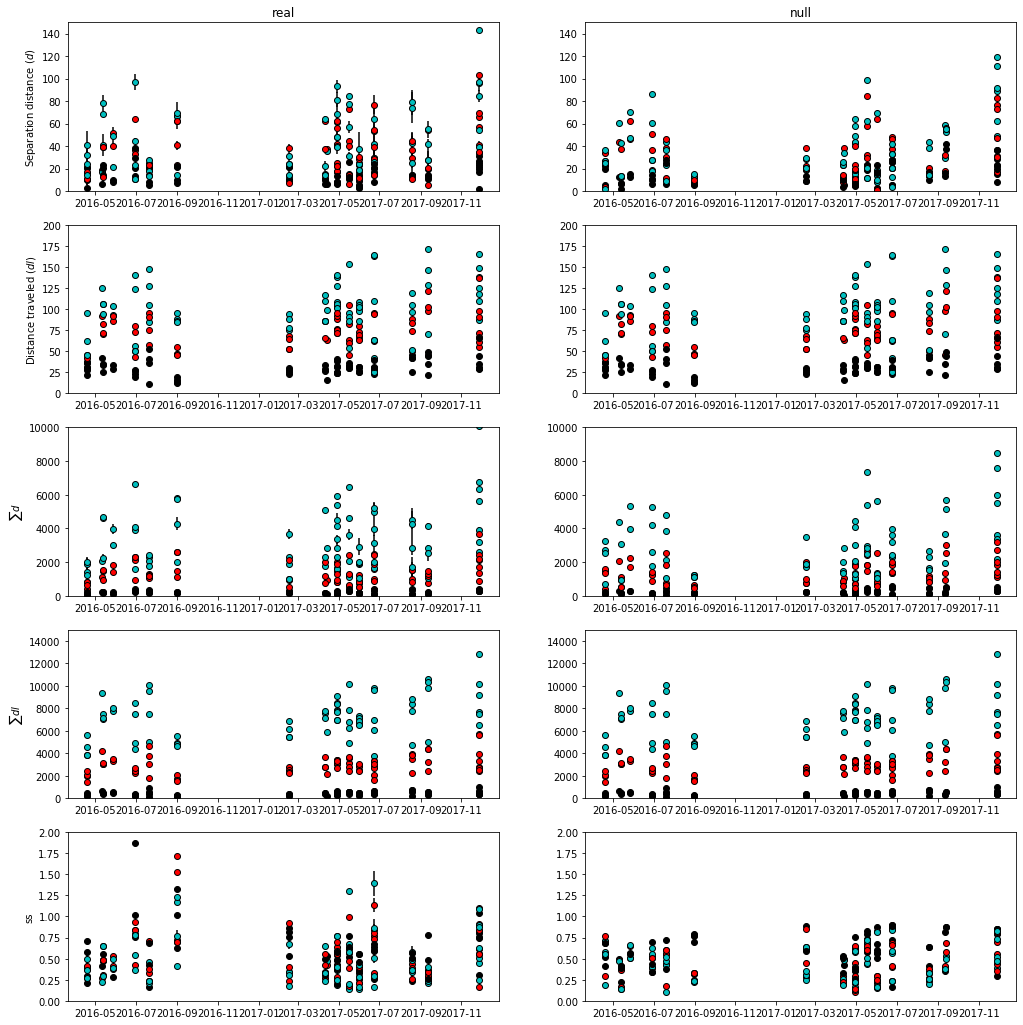

In [77]:
fig, axs = plt.subplots(5, 2, figsize=(17, 18))
for ID in IDs[:128]:
    dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
    start, end = [mtime2datetime(float(drifters['mtime'][dindex][t])) for t in [0, -1]]
    if ((end - start).days >= 5) & (ID <= 207):
        
        metrics = {
            'real': {'dl': np.empty(0), 'd': np.empty((0, 50))},
            'null': {'dl': np.empty(0), 'd': np.empty((0, 50))},
        }

        t_obs = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex]])
        fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
        outfile = os.path.join(paths['out'], fn)
        
        index = 1
        
        with xr.open_dataset(outfile) as data:
            
            lon_0, lat_0 = data.lon[:, 0].values, data.lat[:, 0].values
            t_model = data.time[0, :].values.astype('datetime64[s]').astype(datetime)
            
            for time, lon, lat in zip(t_model, data.lon.values.T, data.lat.values.T):
                ilast = index
                index = abs(t_obs - time).argmin()
                
                for ln, lt, tag in zip([lon, lon_0], [lat, lat_0], ['real', 'null']):
                
                    d = np.sqrt(
                        (ln - drifters['lon'][dindex][index])**2 +
                        (lt - drifters['lat'][dindex][index])**2
                    ) * deg2m * 1e-3

                    dl = np.sqrt(
                        (drifters['lon'][dindex][index] - drifters['lon'][dindex][ilast])**2 +
                        (drifters['lat'][dindex][index] - drifters['lat'][dindex][ilast])**2
                    ) * deg2m * 1e-3

                    metrics[tag]['dl'] = np.append(metrics[tag]['dl'], dl)
                    metrics[tag]['d'] = np.concatenate((metrics[tag]['d'], d[np.newaxis, :]))
        
        for col, tag in zip(axs.T, ['real', 'null']):
            d = metrics[tag]['d']
            I_0 = np.cumsum(metrics[tag]['dl'])[:, np.newaxis]
            d_sum = np.cumsum(d, axis=0)
            I_0_sum = np.cumsum(I_0, axis=0)
            ss = d_sum / I_0_sum
            labels = ['Separation distance ($d$)', 'Distance traveled ($dl$)', '$\sum d$', '$\sum dl$', 'ss']
            lims = [(0, 150), (0, 200), (0, 10000), (0, 15000), (0, 2)]
            col[0].set_title(tag)
            for i, color in zip([24, 72, 120], ['k', 'r', 'c']):
                label = f'{i} hours' if ID == 3 else None
                for ax, label, y, ylim in zip(col, labels, [d[i, :], I_0[i, :], d_sum[i, :], I_0_sum[i, :], ss[i, :]], lims):
                    ax.errorbar(
                        start, y.mean(), yerr=y.std(),
                        fmt='ko', markerfacecolor=color, label=label)
                    ax.set_ylim(ylim)
                    if tag == 'real':
                        ax.set_ylabel(label)

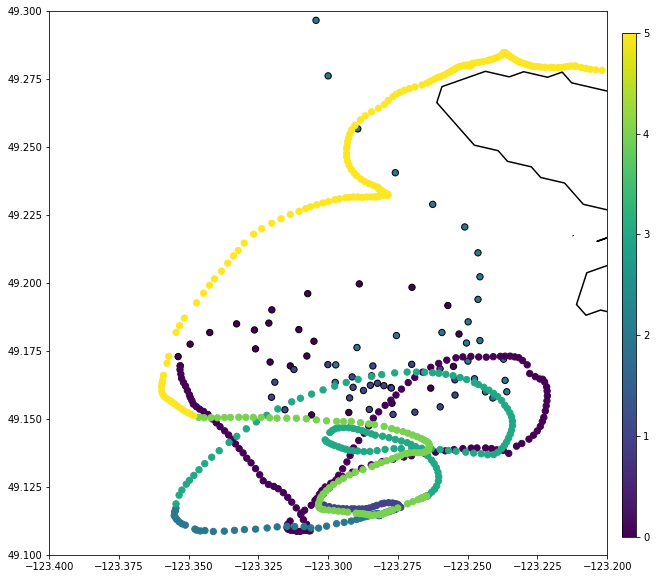

In [137]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.contour(grid.nav_lon, grid.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-123.4, -123.2])
ax.set_ylim([49.1, 49.3])

ID = IDs[0]
dindex = np.where(drifters['id'].astype(int) == ID)[0][0]
start, end = [mtime2datetime(float(drifters['mtime'][dindex][t])) for t in [0, -1]]
if ((end - start).days >= 5) & (ID <= 207):

    metrics = {
        'real': {'dl': np.empty(0), 'd': np.empty((0, 50))},
        'null': {'dl': np.empty(0), 'd': np.empty((0, 50))},
    }

    t_obs = np.array([mtime2datetime(float(t)) for t in drifters['mtime'][dindex]])
    fn = f'drifter{ID:03d}_' + '_'.join(d.strftime('%Y%m%d') for d in [start, start+duration]) + '.nc'
    outfile = os.path.join(paths['out'], fn)

    index = 1

    with xr.open_dataset(outfile) as data:

        lon_0, lat_0 = data.lon[:, 0].values, data.lat[:, 0].values
        t_model = data.time[0, :].values.astype('datetime64[s]').astype(datetime)
        
        hours_obs = [int((t - t_obs[0]).total_seconds()/86400) for t in t_obs]
        hours_model = [int((t - t_model[0]).total_seconds()/86400) for t in t_model]
        
        c = ax.scatter(data.lon[0, :], data.lat[0, :], s=40, c=hours_model, vmin=0, vmax=5, edgecolor='k')
        plt.scatter([l[0] for l in drifters['lon'][dindex]], [l[0] for l in drifters['lat'][dindex]], s=40, c=hours_obs, vmin=0, vmax=5)

        for time, lon, lat in zip(t_model, data.lon.values.T, data.lat.values.T):
            ilast = index
            index = abs(t_obs - time).argmin()

            for ln, lt, tag in zip([lon, lon_0], [lat, lat_0], ['real', 'null']):

                d = np.sqrt(
                    (ln - drifters['lon'][dindex][index])**2 +
                    (lt - drifters['lat'][dindex][index])**2
                ) * deg2m * 1e-3

                dl = np.sqrt(
                    (drifters['lon'][dindex][index] - drifters['lon'][dindex][ilast])**2 +
                    (drifters['lat'][dindex][index] - drifters['lat'][dindex][ilast])**2
                ) * deg2m * 1e-3

                metrics[tag]['dl'] = np.append(metrics[tag]['dl'], dl)
                metrics[tag]['d'] = np.concatenate((metrics[tag]['d'], d[np.newaxis, :]))

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(c, cax=cax)